In this post, we’ll walk through **how to build a CRC (Colorectal Carcinoma) classifier for colorectal cancer detection using processed metagenomics data** from various colorectal cancer cohorts [@thomas2019metagenomic;@wirbel2019meta]. 


The dataset includes **relative abundance data** of microbial species, categorized by their operation taxonomic units (OTU). These OTU organizes species across taxonomic ranks such as **kingdom, class, order, phylum, genus, and species**. The dataset draws on samples from multiple published research studies, offering a rich source of analysis. 


:::{.callout-tip}
# Dataset

You can access the processed dataset [here](http://segatalab.cibio.unitn.it/data/Thomas_et_al.html).

:::

# Analysis pipeline
As our first analysis, we will use a part of the dataset from @zeller2014potential, consisting of samples from 156 french patients. For the analysis, we will refer to analysis pipeline of the same study. 

```{mermaid}
flowchart LR
  A(Data Loading) --> B(Species filtering)
  B --> C(Feature transformation)
  C --> D(Statistical analysis)
  D --> E(Model building)
  F --> E(Model building)
  G --> E(Model building)
  C --> F(Enterotype inference)
  C --> G(PCA)
  E --> H(Generalizability evaluation)
```

* **Data Loading (A)**: The process begins by loading the dataset, which contains relative abundance data and metadata.

* **Species Filtering (B)**: In this step, microbial species are filtered to retain only those relevant for analysis, improving data quality and reducing noise.
* Feature Transformation (C)**: The selected features undergo transformation to prepare the data for statistical analysis and downstream modeling.
* **Statistical Analysis (D)**: Various statistical techniques are applied to identify significant patterns and associations within the data.
* **Model Building (E)**: This central step integrates insights from statistical analysis, enterotype inference, and PCA to develop the CRC classifier.
* **Enterotype Inference (F)**: Enterotypes, or gut microbial community types, are inferred to explore microbiome structure and its potential link to CRC.
* **Principal Component Analysis (PCA) (G)**: PCA reduces data dimensionality, capturing key variance and enhancing model interpretability.
* **Generalizability Evaluation (H)**: Finally, the model’s robustness and generalizability are evaluated to ensure reliable performance across different datasets.

## Data loading

The dataset **includes 156 samples, each characterized by 829 features**. These features encompass **metadata** such as `body_site`, `study_condition` as well as **relative abundance data of microbial species in the human gut microbiome**. Together, these features provide valuable insights into hoy microbial composition varies across different conditions, aiding in the development of an accurate CRC classifier. 

In [2]:
import pandas as pd

# loading tab-seperated data file using pandas and transposing it
data = pd.read_csv('Nine_CRC_cohorts_taxon_profiles.tsv',sep='\t',header=None).T

# setting the first row as column names and then removing it
data = data.rename(columns=data.loc[0]).drop(0, axis=0)

# accessing Zeller et al., 2014 dataset
zeller_db = data.loc[data['dataset_name'] == 'ZellerG_2014',:]

# fetching microbacterial organism information-related columns
bacteria_colnames = [col for col in data.columns if 'k__Bacteria' in col]

# metadata colnames
metadata_colnames = ['dataset_name', 'sampleID', 'subjectID', 'body_site', 'study_condition',
                     'disease', 'age', 'age_category', 'gender', 'country','ajcc','alcohol',
                     'antibiotics_current_use','curator','disease_subtype','ever_smoke','fobt',
                     'hba1c','hdl','ldl','location','BMI']

zeller_db

,dataset_name,sampleID,subjectID,body_site,study_condition,disease,age,age_category,gender,country,...,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Circoviridae|g__Gyrovirus|s__Chicken_anemia_virus,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Geminiviridae|g__Mastrevirus|s__Wheat_dwarf_virus,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Hepadnaviridae|g__Orthohepadnavirus|s__Orthohepadnavirus_unclassified,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Inoviridae|g__Inovirus|s__Enterobacteria_phage_I2_2,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Inoviridae|g__Inovirus|s__Enterobacteria_phage_If1,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Polyomaviridae|g__Polyomavirus|s__JC_polyomavirus,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Retroviridae|g__Gammaretrovirus|s__Porcine_type_C_oncovirus,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Retroviridae|g__Retroviridae_noname|s__Avian_endogenous_retrovirus_EAV_HP,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Enterobacteria_phage_HK544,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Porcine_stool_associated_circular_virus_3
1,ZellerG_2014,CCIS27304052ST-3-0,FR-001,stool,control,none,52,adult,female,FRA,...,0.0,0.61117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZellerG_2014,CCIS13047523ST-4-0,FR-003,stool,control,none,70,senior,male,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0038,0.0,0.0,0.0
3,ZellerG_2014,CCIS15794887ST-4-0,FR-024,stool,control,none,37,adult,female,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZellerG_2014,CCIS94603952ST-4-0,FR-025,stool,control,none,80,senior,female,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ZellerG_2014,CCIS74726977ST-3-0,FR-026,stool,adenoma,adenoma,66,senior,male,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,ZellerG_2014,CCIS48579360ST-4-0,FR-829,stool,adenoma,adenoma,52,adult,female,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,ZellerG_2014,CCIS46467422ST-4-0,FR-830,stool,CRC,CRC,54,adult,female,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,ZellerG_2014,CCIS54027808ST-4-0,FR-835,stool,adenoma,adenoma,52,adult,male,FRA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004,0.0,0.0,0.0
155,ZellerG_2014,CCIS15704761ST-4-0,FR-901,stool,CRC,CRC,56,adult,female,FRA,...,0.0,0.02256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Species filtering
We will first filter out species whose **relative abundance does not exceed 0.001 in any sample**. This **criterion** is derived from the study by Zeller et al., the same study that provided the dataset [@zeller2014potential].

After applying this abundance filter, the dataset is reduced to 214 species. We will now proceed with model development using these filtered species.

In [6]:
import numpy as np
# dataset containing only bacterial microoganism's relative abundace
microbiome = zeller_db[bacteria_colnames]

# change data type from string to float
for species in microbiome.columns:
    microbiome.loc[:,species] = microbiome[species].astype('float32')
    microbiome.loc[:,species] = microbiome[species].apply(lambda x: x if x >=.001 else np.NaN)
    
# removing species having relative abundance less than .001
microbiome_filtered = microbiome.dropna(axis=1,thresh=15)

print('Number of species after filtering:',microbiome_filtered.shape[0])


Number of species after filtering: 156


In [22]:
microbiome.columns

Index(['k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_unclassified',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_schaalii',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_unclassified',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_cardiffensis',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_europaeus',
       'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii',
       'k__Ba

In [21]:
columns_to_remove = microbiome.columns[microbiome.max(axis=1) < 0.001]

columns_to_remove

IndexError: boolean index did not match indexed array along dimension 0; dimension is 699 but corresponding boolean dimension is 156

In [20]:
microbiome.max(axis=1) < .001

1      False
2      False
3      False
4      False
5      False
       ...  
152    False
153    False
154    False
155    False
156    False
Length: 156, dtype: bool

In [180]:

import seaborn as sns
import numpy as np
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')




# functions to process the data and prepare in a format supporting phyloseq analysis
def get_sample_table(df):
    df = df[metadata_colnames]
    df = df.set_index('subjectID')
    df.drop(['dataset_name','sampleID'],axis=1,inplace=True)
    return df

def get_otu_table(df):
    df = df[bacteria_colnames + ['subjectID']]
    df.columns = ["OTU_{}".format(str(ind)) for ind, col in enumerate(bacteria_colnames)] + ['subjectID']
    df.index = df['subjectID']
    taxa_table = get_taxa_table(bacteria_colnames)
    return df, taxa_table

def get_taxa_table(list_of_otus):
    otu = 0
    mapping = {}
    taxa_cols = ['kingdom','phylum','class','order','family','genus','species']
    df = pd.DataFrame(columns=taxa_cols)
    otu_mapping = {}
    otu_ids = []
    for ind, otu in enumerate(list_of_otus):
        tmp = {}
        for col in taxa_cols:
            tmp[col] = get_specific_label(otu, col)
        tmp_df = pd.DataFrame([tmp])
        df = pd.concat([df,tmp_df], ignore_index=[0])

        otu_id = "OTU_{}".format(str(ind))
        otu_mapping[otu] = otu_id
        otu_ids.append(otu)

    df['OTU'] = ['OTU_{}'.format(str(ind)) for ind in df.index]
    df = df.set_index('OTU')
    return df


def get_specific_label(l, t):
    """
    This function parse the taxonomic assignment lable and fetch the specified information (e.g., kingdom, family)

    Args:
        l (str): string of taxonomy
        t (str): string specifying the requested information (e.g., kingdom, family, genus, etc.)

    Returns:
        str: requested heirarichal info 
    """
    taxa_order = {'kingdom':0,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}

    try:
        specific_label = l.split('|')[taxa_order[t]]

        return specific_label.strip().split('__')[1]
    except:
        return 'Unknown'

    
def get_otu_detail(taxa_table, otu_label, rank):
    return taxa_table[otu_label][rank]


def aggregate_by_taxonomy(otu_table, taxa_table, taxa_rank):
    """
    This function aggregate data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    """
    unique_values = (taxa_table[taxa_rank].unique())

    # mapping for otus to unique value of chosen taxa rank
    taxa_to_otu = {}

    # prepare the mapping
    for unique_value in unique_values:
        tdf = taxa_table.loc[taxa_table[taxa_rank] == unique_value, :]
        otus = tdf.index.to_list()   
        taxa_to_otu[unique_value.strip()] = otus
    
    
    # create a dictionary for formulating expressions
    taxa_to_exp = {}

    for key in taxa_to_otu.keys():
        taxa_to_exp[key] = '{} = 0'.format(key)
        for otu in taxa_to_otu[key]:
            taxa_to_exp[key] += ' + ' + otu
            otu_table[otu] = otu_table[otu].astype('float')

    agg_df = otu_table

    for key, expr in taxa_to_exp.items():
        agg_df[key] = 0
        agg_df = agg_df.eval(expr, engine='python')
        
    agg_df = agg_df[list(unique_values)]
    
    return agg_df   

## Expanding target classes
Now we will expand our target classes for modeling task. In the dataset, column `study_condition` contains **three different types of classes: control, adenoma, and CRC**. For our classification task, we will further expand CRC class into two sub-classes: **early_stage and late_stage**. 

We will use here the same nomenclature used in Zeller et al. (2014): **No neoplasma, Adenoma, Early stage (0/1/2) and Late stage(stage 3/4)**. The figure below shows the distribution of target class.

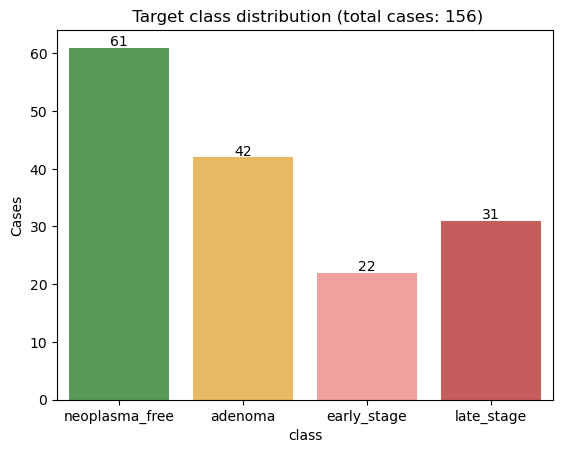

In [232]:
color_palette = {'neoplasma_free':'green',
                'adenoma':'orange',
                'early_stage':'#ff6464',
                'late_stage':'#c80000'}

metadata = zeller_db[metadata_colnames]

metadata.loc[:,'class'] = 'neoplasma_free'
metadata.loc[metadata['ajcc'].isin(['i','ii']),'class'] = 'early_stage'
metadata.loc[metadata['ajcc'].isin(['iii','iv']),'class'] = 'late_stage'
metadata.loc[metadata['study_condition'] == 'adenoma','class'] = 'adenoma'

ax = sns.countplot(data = metadata, x='class',palette = color_palette, alpha=.7)
for p in ax.patches:
    height = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height}', 
            ha="center", va="center")


plt.ylabel('Cases')
plt.title(' Target class distribution (total cases: 156)')
plt.show()

## Metadata exploration
We will now take a step further in our exploration and investigate for statistical differences among target classes in terms of patient demographics. 

We used **Mann-Whitney** statistical test to investigate statistical significance of differences. Our results showed that there are 
The below figures show that **there are statistical significant differences between `neoplasma free` and `early stage` CRC. These differences were also found between `neoplasma free` and `adenoma`.**

:::{.callout-note}
# Age

We noticed **statistical differences in age of groups neoplasma-free and early-stage CRC, ** and **adenoma and early-stage CRC**.

:::

In [243]:
from statannot import add_stat_annotation

# changing data type of age and BMI
metadata['age'] = pd.to_numeric(metadata.age, errors='coerce')
metadata['BMI'] = pd.to_numeric(metadata.BMI, errors='coerce')

order = ['neoplasma_free', 'adenoma', 'early_stage', 'late_stage']
x = 'class'

pairs = [
    ('neoplasma_free','adenoma'),
    ('neoplasma_free','early_stage'),
    ('neoplasma_free','late_stage'),
    ('adenoma','early_stage'),
    ('adenoma','late_stage'),
]


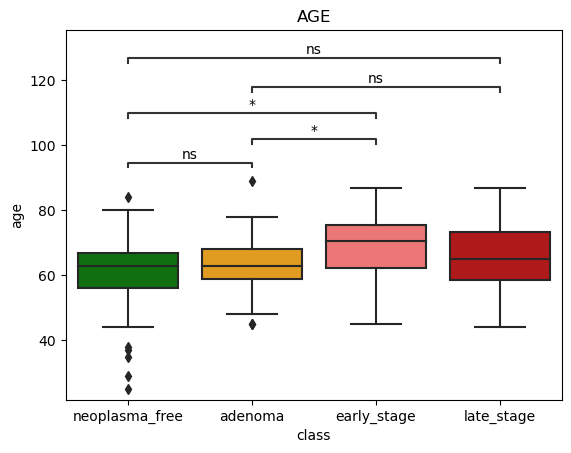

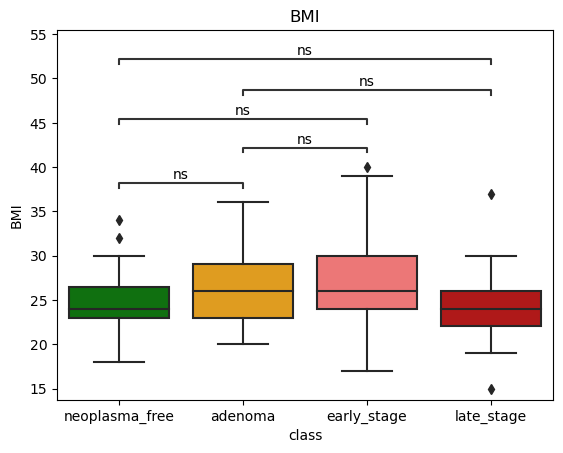

In [251]:
#| label: fig-stat-meta
#| fig-cap: "Age/BMI distribution"
#| fig-subcap: 
#|   - "Age"
#|   - "BMI"
#| layout-ncol: 2
# plotting distribution

for ind, y in enumerate(['age','BMI']):
    plt.figure()
    ax = sns.boxplot(data=metadata, y=y,x=x, palette=color_palette, order= order)
    #annot = Annotator(ax, pairs=pairs, data=metadata, x=x, y=y, hue=x, hue_order=order, order=order)
    ax, test_results = add_stat_annotation(ax, box_pairs=pairs, data=metadata, x=x, y=y,
                                           hue_order=order, order=order,
                                           test='Mann-Whitney', text_format='star',comparisons_correction=None, 
                                           loc='inside', verbose=False)

    plt.title(f'{y.upper()}')

    plt.show()

## CRC classifier based on metadata
Now, we will build a CRC classifier using `gender`,`age` and `BMI` data. This will help us setting a performance baseline for our metagenomic classifier (the one we will build in the later stage using relative abundance data). 

For this classification task, we will **merge control and adenoma into negative class (0) and early and late stages into positive class (1)**. 

In [351]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

# accessing data
X = metadata[['age','BMI','gender']]
y = metadata['class']

# reset indices
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# transforming data into numeric format
X['gender'] = X['gender'].map({'female':0,'male':1})
X['gender'] = pd.to_numeric(X['gender'], errors='coerce')
X['age'] = pd.to_numeric(X['age'], errors='coerce')
X['BMI'] = pd.to_numeric(X['BMI'], errors='coerce')

# mean imputation for missing values
X = X.interpolate(method='linear')
#X.drop(['subjectID'],axis=1,inplace=True)

# coverting class into two classes
y_num = y.map({'neoplasma_free':0, 'adenoma':0, 'early_stage':1, 'late_stage':1})

def build_classifier(X,y, plot_auc=True, title=""):
    # Outer validation: 10-fold cross-validation
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Inner validation: 5-fold cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define a Lasso model (L1-regularized logistic regression)
    lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, multi_class='multinomial')

    # Set up a pipeline for scaling and training
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale features
        ('lasso', lasso)
    ])

    # Nested cross-validation
    outer_scores = []

    param_grid = {'lasso__C': np.logspace(-3, 3, 10)}  # Test regularization strength

    # Plot ROC curve for each fold
    plt.figure(figsize=(7, 5))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]

        # Perform GridSearchCV with 10-fold cross-validation
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring='roc_auc_ovr', cv=inner_cv, n_jobs=-1
        )

        # searching parameters first
        grid_search.fit(X_train, y_train)

        # Best model and hyperparameter
        best_model = grid_search.best_estimator_
        #print(f"Best Hyperparameter: {grid_search.best_params_}")

        # Fit the model and predict probabilities
        best_model.fit(X_train, y_train)
        y_prob = best_model.predict_proba(X_test)


        fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)

        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolating to the same FPR grid
        tprs[-1][0] = 0.0  # Ensure TPR starts at 0

        #plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

    # Average AUC across classes
    mean_auc = np.mean(aucs)

    # Plot the mean ROC curve
    # Calculate mean and standard deviation of TPRs
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    mean_auc = auc(mean_fpr, mean_tpr)
    
    if plot_auc:

        # Plot the mean ROC curve
        plt.plot(mean_fpr, mean_tpr, color='blue', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')

        # Fill the area between the mean TPR and ±1 standard deviation
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='± 1 Std. Dev.')

        
        
        # Plot the random chance line
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Chance')


        # Finalize the plot
        plt.title(title)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        #plt.grid(alpha=0.3)
        plt.show()
        
    return

The figure below shows AUC performance of our metadata-based model. This model was using `age`, `gender` and `BMI` achieved a performance of **.63 AUC**. This performance is close to the performance of **.62 AUC** reported by Zeller et al. (2014). 

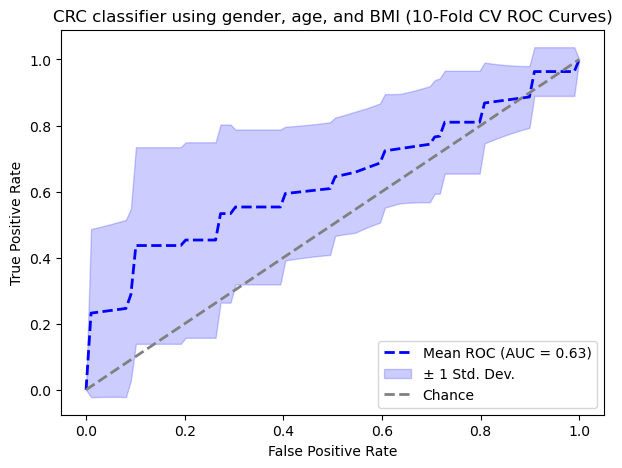

In [290]:
#| label: fig-model-meta
#| fig-cap: "Metadata-based CRC classifier performance (AUC)"

build_classifier(X,y_num,title='CRC classifier using gender, age, and BMI (10-Fold CV ROC Curves)')

## CRC classifier using global metrics (e.g., alpha diversity)


Now we will extend our feature set by including measures of commmunity composition. For this task, we will utilize different kinds of alpha diversity metrics. These metrices are the following

* Shannon index
* Chao1
* Simpson
* Simpson_e
* Fisher alpha
* Berger parker


Our new classifier gained improvement for the classification task for **tumor-free patients** and **CRC patients**. The new performance is **AUC = .74** using alpha diversity measures at **phylum** level. The use of same measures but at genus level, however, downgraded the performance (.60 AUC). 

[@fig-model-meta-alpha] shows the AUC curves for models using alpha diversity measures at genus and phylum levels.

In [283]:
from skbio.diversity import alpha

phylum_agg = aggregate_by_taxonomy(otu_table, taxa_table, 'phylum')
genus_agg = aggregate_by_taxonomy(otu_table, taxa_table, 'genus')

def extend_with_alpha(df, metadata_features):
    diversity_measures = pd.DataFrame()

    alpha_diversity_metrics = [
        "chao1",
        "shannon",
        "simpson",
        "simpson_e",
        "fisher_alpha",
        "berger_parker"
    ]

    shannon_diversity = df.apply(lambda x: alpha.shannon(x), axis=1)
    chao1_diversity   = df.apply(lambda x: alpha.chao1(x), axis=1)
    simpson_diversity   = df.apply(lambda x: alpha.simpson(x), axis=1)
    simpson_e_diversity   = df.apply(lambda x: alpha.simpson_e(x), axis=1)
    fisher_diversity   = df.apply(lambda x: alpha.fisher_alpha(x), axis=1)
    berger_parker_diversity   = df.apply(lambda x: alpha.berger_parker_d(x), axis=1)

    diversity_measures['shannon'] = shannon_diversity
    diversity_measures['chao1'] = chao1_diversity
    diversity_measures['simpson'] = simpson_diversity
    diversity_measures['simpson_e'] = simpson_e_diversity
    diversity_measures['fisher_alpha'] = fisher_diversity
    diversity_measures['berger_parker'] = berger_parker_diversity
    
    X_alpha = diversity_measures.reset_index().drop(['subjectID'], axis=1)
    X_extended = pd.concat([metadata_features,X_alpha],axis=1)
    
    return X_extended

X_genus_alpha = extend_with_alpha(genus_agg, X)
X_phylum_alpha = extend_with_alpha(phylum_agg, X)

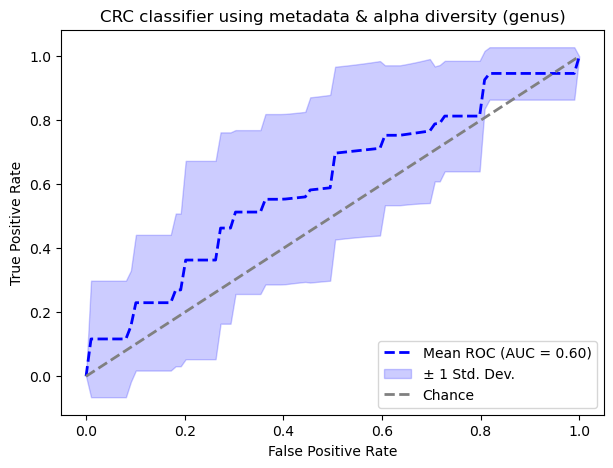

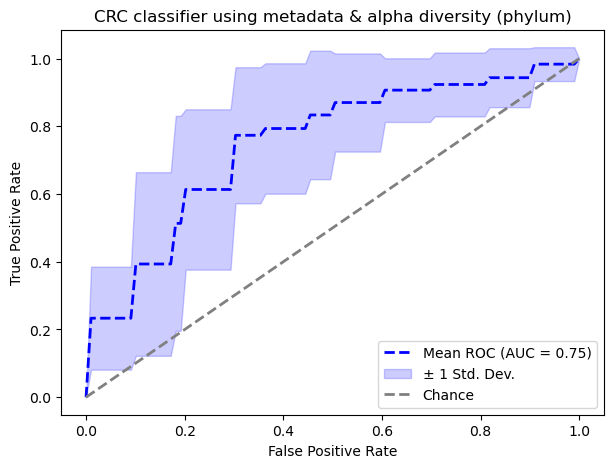

In [291]:
#| label: fig-model-meta-alpha
#| fig-cap: "Metadata & microbiol composition metrices CRC classifier performance (AUC)"
#| fig-subcap: 
#|   - "Area under the ROC cuver ($\\alpha$ measures at Genus level)"
#|   - "Area under the ROC cuver ($\\alpha$ measures at Phylum level)"
#| layout-ncol: 2
build_classifier(X_genus_alpha, y_num, title='CRC classifier using metadata & alpha diversity (genus)')
build_classifier(X_phylum_alpha, y_num, title='CRC classifier using metadata & alpha diversity (phylum)')

### Building metagenomic CRC classifier
Now, we will move towards building a CRC classifier using relative abudance data of species which we obtained after our filtering (see above for the info).

We used **22 microbial species** which were selected in Zeller et al. (2014). These species are given below.


```
selected_species = [
    'Fusobacterium_nucleatum',
    'Eubacterium_rectale',
    'Eubacterium_ventriosum',
    'Peptostreptococcus_stomatis',
    'Porphyromonas_asaccharolytica',
    'Clostridium_symbiosum',
    'Clostridium_hylemonae',
    'Bacteroides_fragilis',
    'Lactobacillus_salivarius',
    'Fusobacterium_gonidiaformans',
    'Lactobacillus_ruminis',
    'Eubacterium_rectale',
    'Bacteroides_caccae',
    'Eubacterium_ventriosum',
    'Clostridium_scindens',
    'Eubacterium_eligens',
    'Bifidobacterium_angulatum',
    'Dorea_formicigenerans',
    'Butyrivibrio_crossotus',
    'Phascolarctobacterium_succinatutens',
    'Ruminococcus_sp',
    'Streptococcus_salivarius',
]
```

In [371]:
# fetching all microbial species 
microbiome_org = zeller_db[bacteria_colnames]

# transforming column names to species name
columns_species = [get_specific_label(item, 'species') for item in microbiome_org.columns]

microbiome_org.columns = columns_species

# fetching selected species data only
microbiome_selected = microbiome_org[selected_species]

microbiome_selected.reset_index(drop=True, inplace=True)

for col in microbiome_selected:
    microbiome_selected[col] = microbiome_selected[col].astype('float32')

X_metadata_species = pd.concat([microbiome_selected,X],axis=1)


/Users/pankaj/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


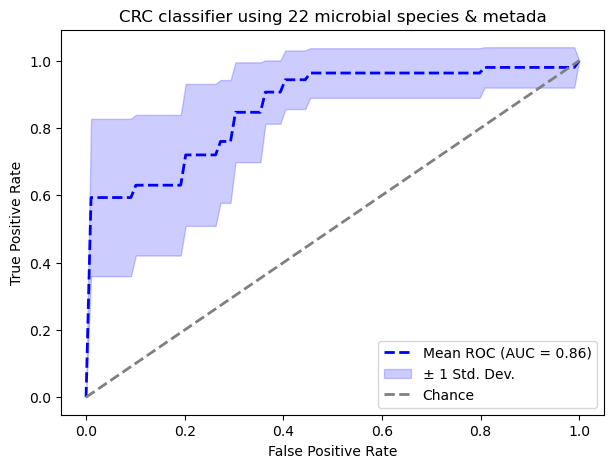

In [373]:
#| label: fig-model-meta-species
#| fig-cap: "Metadata & microbiol species CRC classifier performance (AUC)"

build_classifier(X_metadata_species, y_num, title='CRC classifier using 22 microbial species & metada')

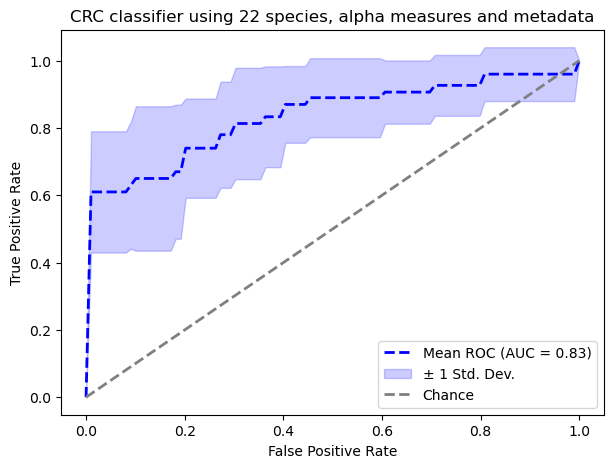

In [380]:
#| label: fig-model-meta-species-alpha
#| fig-cap: "Metadata & microbiol species CRC classifier performance (AUC)"

X_phylum_alpha_species = pd.concat([X_phylum_alpha, microbiome_selected],axis=1)

build_classifier(X_phylum_alpha_species, y_num, 
                 title='CRC classifier using 22 species, alpha measures and metadata')

## Distribution of 22 selected microbial species across different classes

The following figure shows the distribution of selecetd microbial species across different target groups.

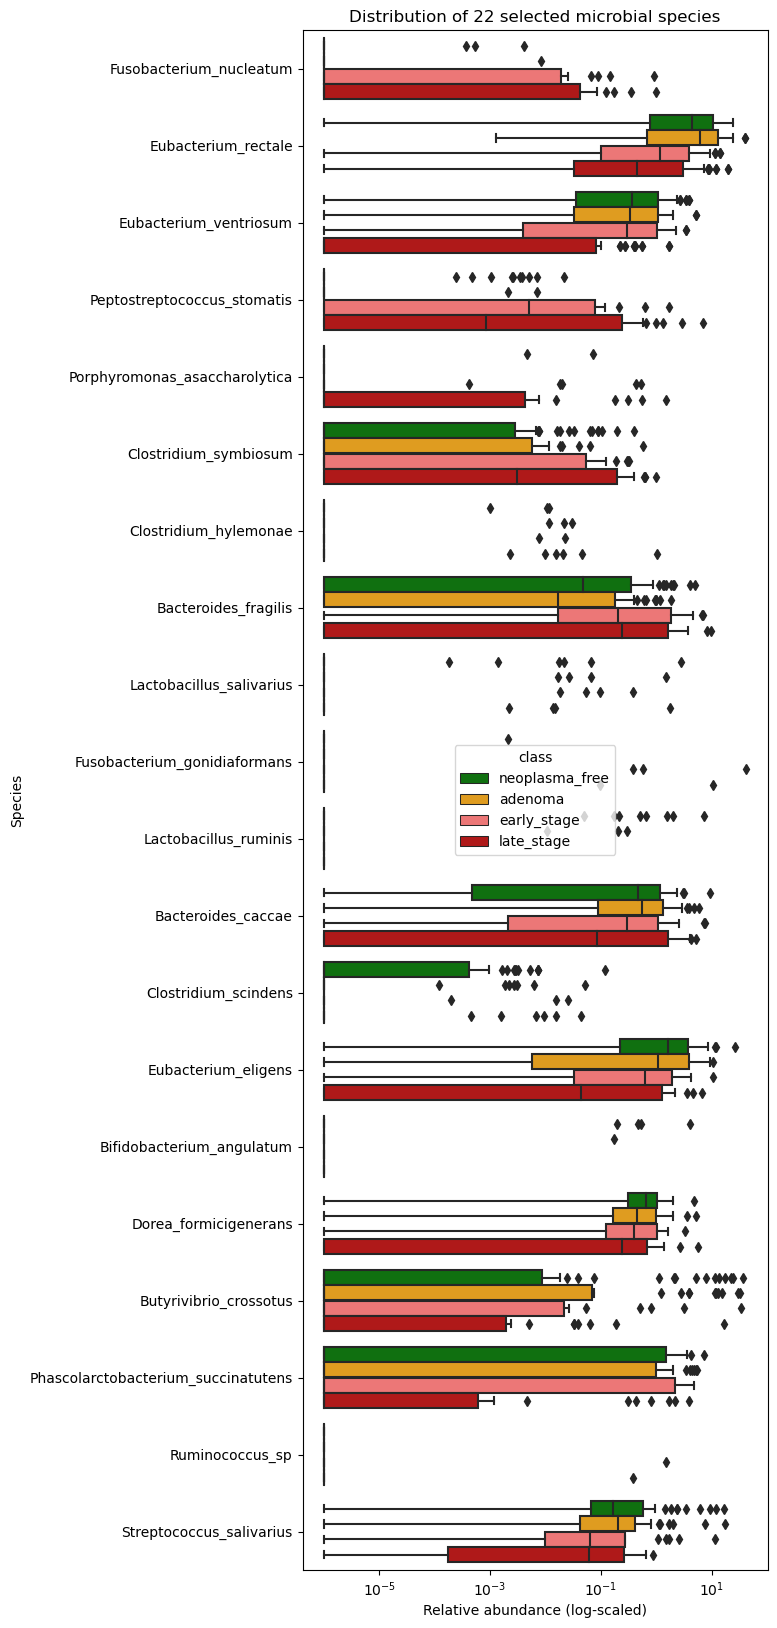

In [369]:
X_metadata_species = pd.concat([microbiome_selected,metadata.reset_index()],axis=1)
melted_df = X_metadata_species.melt(id_vars=[ 'class'],value_vars=selected_species)

melted_df['value'] = melted_df['value'] + .000001

plt.figure(figsize=(6,20))
sns.boxplot(data=melted_df, x='value', y='variable', hue='class', palette = color_palette)
plt.xlabel('Relative abundance (log-scaled)')
plt.ylabel('Species')
plt.xscale('log')
plt.title('Distribution of 22 selected microbial species')
plt.show()